#### Input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
imported = pd.read_csv('housing_bos.csv',header=None, delimiter=r'\s+')

In [3]:
data = imported.copy()

In [4]:
columns = 'CRIM ZN INDUS CHAS NOX ROOMS_PER_HOUSE AGE<1940 DIS RAD TAX PUPILTEACHERRATIO B LSTATUS% PRICE'.split()

In [5]:
data.columns = columns
data.head()


,CRIM,ZN,INDUS,CHAS,NOX,ROOMS_PER_HOUSE,AGE<1940,DIS,RAD,TAX,PUPILTEACHERRATIO,B,LSTATUS%,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


array([[<Axes: title={'center': 'CRIM'}>, <Axes: title={'center': 'ZN'}>,
        <Axes: title={'center': 'INDUS'}>,
        <Axes: title={'center': 'CHAS'}>],
       [<Axes: title={'center': 'NOX'}>,
        <Axes: title={'center': 'ROOMS_PER_HOUSE'}>,
        <Axes: title={'center': 'AGE<1940'}>,
        <Axes: title={'center': 'DIS'}>],
       [<Axes: title={'center': 'RAD'}>, <Axes: title={'center': 'TAX'}>,
        <Axes: title={'center': 'PUPILTEACHERRATIO'}>,
        <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'LSTATUS%'}>,
        <Axes: title={'center': 'PRICE'}>, <Axes: >, <Axes: >]],
      dtype=object)

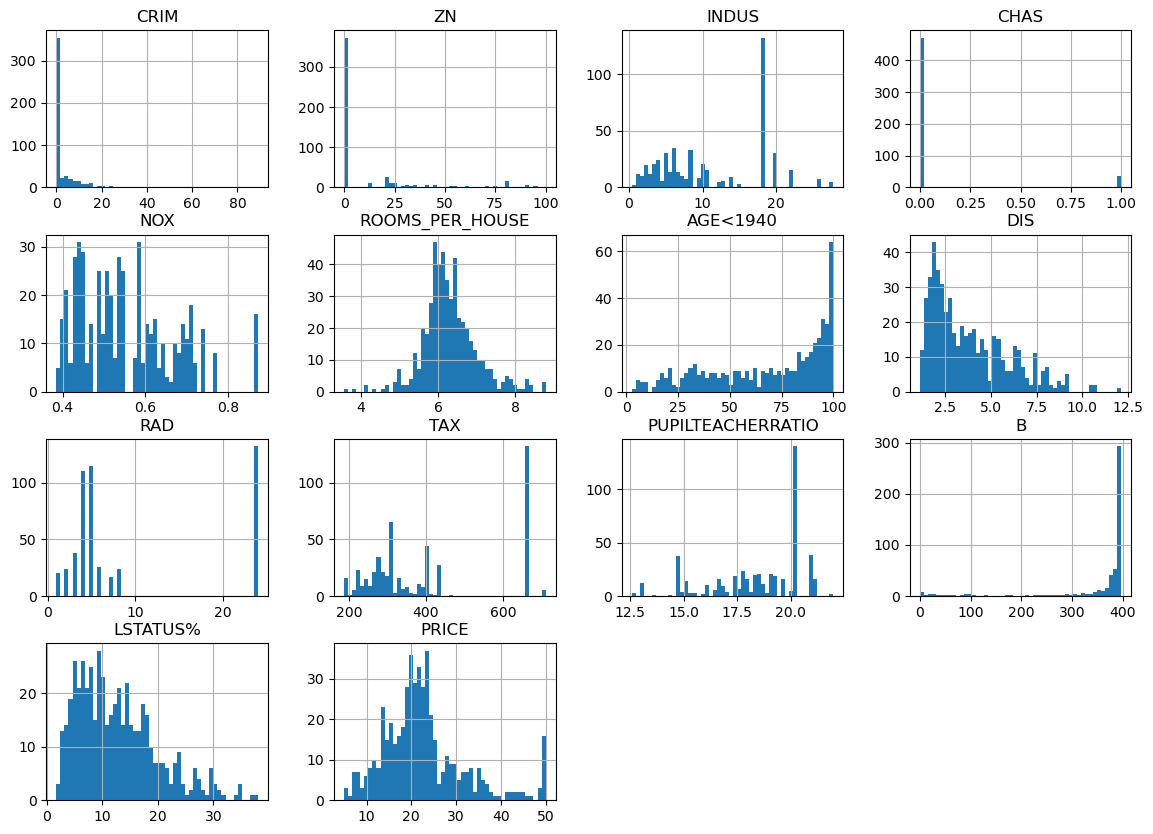

In [6]:
data.hist(figsize=(14,10), bins=50)

In [8]:

data.corrwith(data['PRICE']).sort_values(ascending=False)

PRICE                1.000000
ROOMS_PER_HOUSE      0.695360
ZN                   0.360445
B                    0.333461
DIS                  0.249929
CHAS                 0.175260
AGE<1940            -0.376955
RAD                 -0.381626
CRIM                -0.388305
NOX                 -0.427321
TAX                 -0.468536
INDUS               -0.483725
PUPILTEACHERRATIO   -0.507787
LSTATUS%            -0.737663
dtype: float64

### We can see that price is really dependent on rooms per house and Lstatus % which is equal to 1/2 of proportion of adults without, some high school education and proportion of male workers classified as laborers

In [9]:
data = data.drop('CHAS', axis=1)

In [10]:
room_ratio_bins = pd.cut(data['ROOMS_PER_HOUSE'], bins=[0,2.5,5,7.5,10], labels=[1,2,3,4])
data['ROOM_RATIO_BINS'] = room_ratio_bins

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data['PRICE'], test_size=0.2, stratify=room_ratio_bins, random_state=42)

In [12]:
X_train['ROOM_RATIO_BINS'].value_counts() / len(data)

ROOM_RATIO_BINS
3    0.731225
4    0.041502
2    0.025692
1    0.000000
Name: count, dtype: float64

In [13]:
for set in (X_train, X_test):
    set.drop('ROOM_RATIO_BINS', axis=1, inplace=True)

In [14]:
housing_train = X_train.drop('PRICE', axis=1)
training_labels = X_train['PRICE'].copy()

In [82]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import make_pipeline, Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

In [78]:
class Bucketizer(BaseEstimator, TransformerMixin):
    def __init__(self, bins, labels=None):
        self.bins = bins
        self.labels = labels
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        bucketized = pd.cut(X, bins=self.bins, labels=self.labels)
        return bucketized

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out='one-to-one', validate=False),
    StandardScaler()
    )


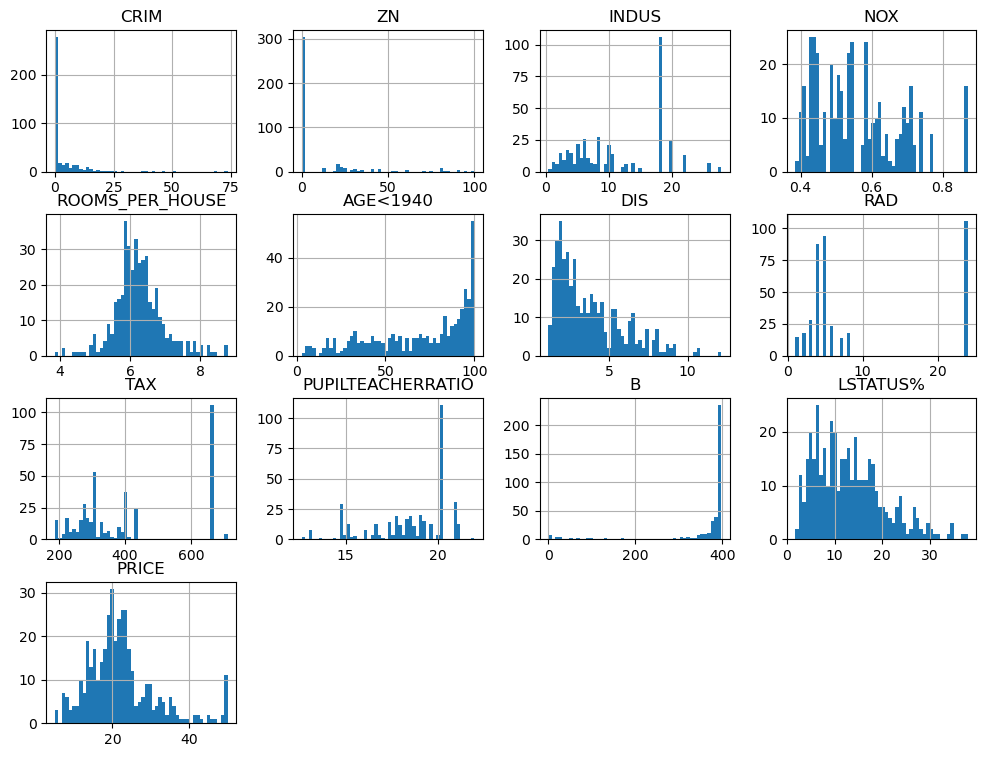

In [64]:
X_train.hist(bins=50, figsize=(12,9));

In [123]:
X_train.PRICE.max()

50.0

In [65]:
log_columns = ['CRIM', 'DIS', 'INDUS']
bucket_columns = ['B', 'PUPILTEACHERRATIO', 'TAX', 'RAD', 'AGE<1940', 'NOX', 'INDUS']

In [96]:
pipeline1 = ColumnTransformer([
    ('log',log_pipeline, log_columns),
    ('bucket', KBinsDiscretizer(5,encode='ordinal', strategy='uniform',subsample=200_000, random_state=42), bucket_columns)
])
processed = pipeline1.fit_transform(X_train)
features_out = pipeline1.get_feature_names_out()

In [97]:
processed_df = pd.DataFrame(processed, columns=features_out, index=X_train.index)

In [99]:
processed_df.head()

,log__CRIM,log__DIS,log__INDUS,bucket__B,bucket__PUPILTEACHERRATIO,bucket__TAX,bucket__RAD,bucket__AGE<1940,bucket__NOX,bucket__INDUS
377,1.409976,-1.618778,0.910731,4.0,4.0,4.0,4.0,4.0,2.0,3.0
354,-1.135084,2.230628,-2.033965,4.0,4.0,1.0,0.0,0.0,0.0,0.0
395,1.353964,-1.169594,0.910731,4.0,4.0,4.0,4.0,4.0,3.0,3.0
372,1.329153,-1.963978,0.910731,4.0,4.0,4.0,4.0,4.0,2.0,3.0
396,1.168843,-1.223480,0.910731,4.0,4.0,4.0,4.0,4.0,3.0,3.0


In [105]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(pipeline1, LinearRegression())
lin_reg.fit(X_train, y_train)
linear_predictions = lin_reg.predict(X_train)
print(linear_predictions[:5].round(2))
print(y_train[:5].round(2))

[21.56 21.65 16.89 22.8  17.1 ]
377    13.3
354    18.2
395    13.1
372    50.0
396    12.5
Name: PRICE, dtype: float64


In [112]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_train, linear_predictions)
rmse

6.255040379875398

In [111]:
from sklearn.tree import  DecisionTreeRegressor
tree_reg = make_pipeline(pipeline1, DecisionTreeRegressor())
tree_reg.fit(X_train, y_train)
tree_predictions = tree_reg.predict(X_train)

In [114]:
root_mean_squared_error(y_train, tree_predictions)

0.0

#### Overfitted so we use cross validation

In [125]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

In [126]:
pd.Series(tree_rmses).describe()

count    10.000000
mean      7.367090
std       1.633829
min       4.844962
25%       6.435523
50%       7.675516
75%       8.763314
max       9.186593
dtype: float64

In [127]:
from sklearn.ensemble import RandomForestRegressor
for_reg = make_pipeline(pipeline1, RandomForestRegressor(random_state=42))
for_rmses = cross_val_score(for_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(for_rmses).describe()

count    10.000000
mean     -5.753470
std       1.207971
min      -7.464357
25%      -6.358362
50%      -5.617906
75%      -5.272089
max      -3.379392
dtype: float64

### WOW 